<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
%load_ext autoreload
%autoreload 2

In [18]:
!{sys.executable} -m pip install torchtext==0.2.3

    100% |████████████████████████████████| 51kB 2.0MB/s 
  Running setup.py bdist_wheel for torchtext ... - done
  Stored in directory: /root/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
import torch
import torchvision
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *


In [20]:
print(torch.__version__)
print(torch.cuda.is_available())

0.3.1
True


In [0]:
path = 'data/mnist/'

In [0]:
import os
os.makedirs(path, exist_ok=True)

In [0]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [24]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

mnist.pkl.gz: 16.2MB [00:06, 2.51MB/s]                            


In [27]:
type(x), x.shape, type(y), y.shape, type(x_valid), x_valid.shape, type(y_valid), y_valid.shape

(numpy.ndarray,
 (50000, 784),
 numpy.ndarray,
 (50000,),
 numpy.ndarray,
 (10000, 784),
 numpy.ndarray,
 (10000,))

In [0]:
mean = x.mean()
std = x.std()

In [29]:
x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [30]:

x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [0]:

def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [0]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

In [33]:
x_valid.shape

(10000, 784)

In [34]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

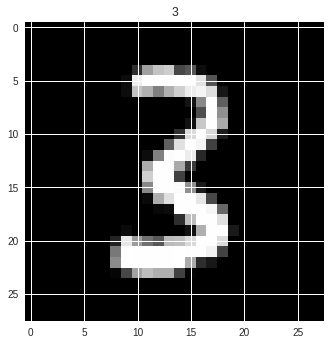

In [35]:
show(x_imgs[0], y_valid[0])

In [36]:
y_valid.shape

(10000,)

In [37]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

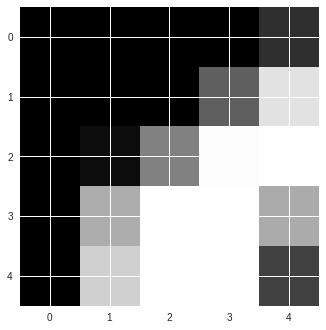

In [38]:
show(x_imgs[0,10:15,10:15])

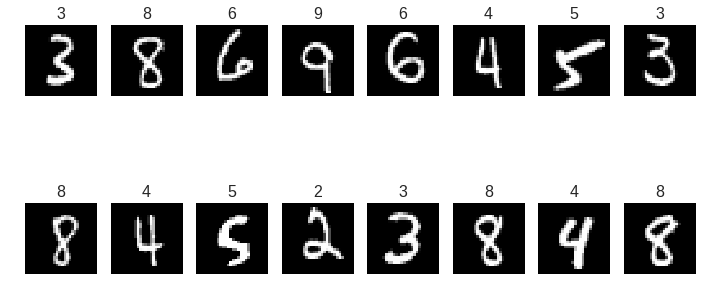

In [40]:
plots(x_imgs[:16], titles=y_valid[:16])

In [0]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [0]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
).cuda()

In [0]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [0]:
loss=nn.NLLLoss()
metrics=[accuracy]
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)